In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/flowers_dataset/flowers

rose  sunflower  tulip


установка библиотек

In [ ]:
# Установка и импорт библиотек
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Явный импорт ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

Шаг 3: Загрузка и предобработка данных
Адаптируем функцию для загрузки данных с учётом нового пути и трёх классов

In [ ]:
# Путь к датасету в Google Drive
data_dir = '/content/drive/MyDrive/flowers_dataset/flowers'

# Параметры изображений
img_height, img_width = 224, 224
batch_size = 32

# Функция для загрузки и предобработки данных
def load_and_preprocess_data(data_dir, batch_size=32, img_height=224, img_width=224):
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Нормализация пикселей
        validation_split=0.2,  # 20% данных для валидации
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

# Загрузка данных
train_gen, val_gen = load_and_preprocess_data(data_dir)

Found 2003 images belonging to 3 classes.
Found 498 images belonging to 3 classes.


Шаг 4: Создание и обучение базовой модели

In [ ]:
# Создание базовой модели
def create_base_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Замораживаем слои

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 класса (rose, sunflower, tulip)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Обучение базовой модели
base_model = create_base_model()
history = base_model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 815ms/step - accuracy: 0.7206 - loss: 0.6338 - val_accuracy: 0.8715 - val_loss: 0.3118
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 684ms/step - accuracy: 0.8913 - loss: 0.2984 - val_accuracy: 0.8735 - val_loss: 0.3099
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step - accuracy: 0.9064 - loss: 0.2244 - val_accuracy: 0.8635 - val_loss: 0.4062
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.9043 - loss: 0.2365 - val_accuracy: 0.8655 - val_loss: 0.3171
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 681ms/step - accuracy: 0.9109 - loss: 0.2279 - val_accuracy: 0.9016 - val_loss: 0.2795
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 680ms/step - accuracy: 0.9310 - loss: 0.1737 - val_accuracy: 0.8956 - val_loss: 0.2853
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 679ms/step - accuracy: 0.9254 - loss: 0.1956 - val_accuracy: 0.9036 - val_loss: 0.3172
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 678ms/step - accuracy: 0.9494 - loss: 0.1408 - val_accu

Шаг 5: Дообучение модели

In [ ]:
# Дообучение (размораживаем последние слои)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  # Замораживаем первые 100 слоев

# Компилируем с меньшим learning rate
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Дообучение
history_fine = base_model.fit(train_gen, validation_data=val_gen, epochs=5)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 827ms/step - accuracy: 0.9647 - loss: 0.1014 - val_accuracy: 0.8996 - val_loss: 0.3055
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 684ms/step - accuracy: 0.9610 - loss: 0.1112 - val_accuracy: 0.9036 - val_loss: 0.3184
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 684ms/step - accuracy: 0.9629 - loss: 0.1106 - val_accuracy: 0.8795 - val_loss: 0.3333
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 704ms/step - accuracy: 0.9713 - loss: 0.0956 - val_accuracy: 0.9116 - val_loss: 0.2673
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 728ms/step - accuracy: 0.9738 - loss: 0.0875 - val_accuracy: 0.9036 - val_loss: 0.2833


Шаг 6: Визуализация результатов

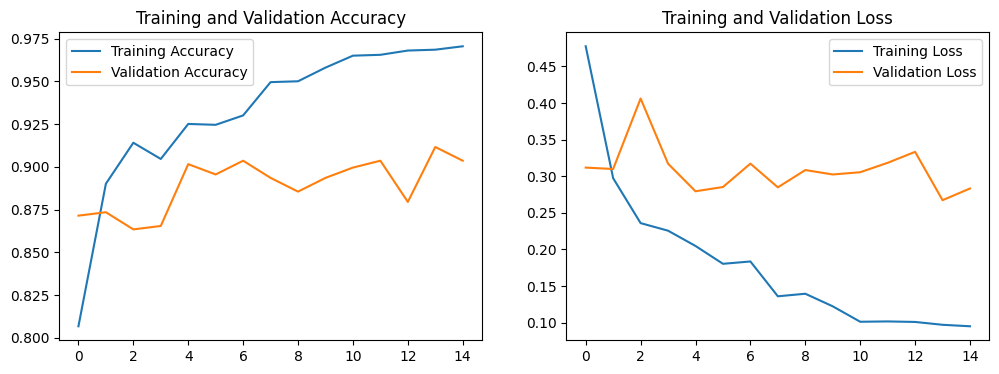

In [ ]:
# Визуализация обучения
def plot_training_history(history, history_fine):
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Визуализация
plot_training_history(history, history_fine)

Шаг 7: Предсказание и визуализация

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


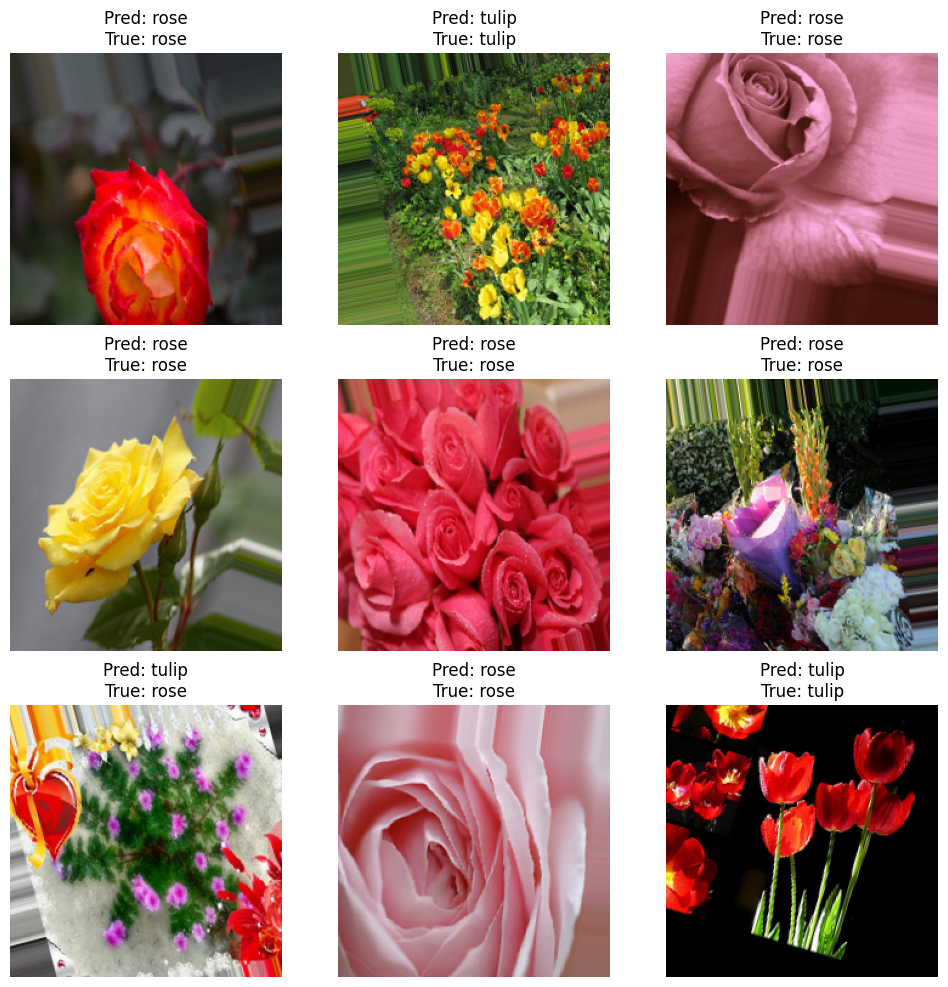

In [ ]:
# Предсказание и визуализация
def predict_and_visualize(model, validation_generator, class_names):
    images, labels = next(validation_generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f'Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}')
        plt.axis('off')
    plt.show()

# Названия классов
class_names = list(train_gen.class_indices.keys())
predict_and_visualize(base_model, val_gen, class_names)